In [2]:
%load_ext autoreload
%autoreload 2
import netCDF4
import xarray as xr
from pathlib import Path
from hmpai.pytorch.models import *
from hmpai.training import split_data_on_participants, split_participants
from hmpai.pytorch.training import train, validate, calculate_class_weights, train_and_test, k_fold_cross_validate, test, calculate_global_class_weights, EarlyStopper
from hmpai.pytorch.utilities import DEVICE, set_global_seed, get_summary_str, save_model, load_model
from hmpai.pytorch.generators import SAT1Dataset, MultiXArrayDataset, MultiXArrayProbaDataset
from hmpai.data import SAT1_STAGES_ACCURACY, SAT_CLASSES_ACCURACY
from hmpai.visualization import plot_confusion_matrix
from hmpai.pytorch.normalization import *
from torchinfo import summary
from hmpai.utilities import print_results, CHANNELS_2D, AR_SAT1_CHANNELS
from torch.utils.data import DataLoader
from torchvision.transforms import Compose
from hmpai.pytorch.transforms import *
from hmpai.pytorch.mamba import *
from hmpai.behaviour.sat2 import SAT2_SPLITS
# from braindecode.models.eegconformer import EEGConformer
from mne.io import read_info
import os
DATA_PATH = Path(os.getenv("DATA_PATH"))

In [3]:
set_global_seed(42)
# data_path_1 = DATA_PATH / "sat2/stage_data_proba_250hz_part1.nc"
# data_path_2 = DATA_PATH / "sat2/stage_data_proba_250hz_part2.nc"
# data_paths = [data_path_1, data_path_2]
# data_paths = [DATA_PATH / "sat2/stage_data_proba_250hz.nc"]
data_paths = [DATA_PATH / "sat2/stage_data_proba_250hz_step5_50.nc"]
# data_paths = [DATA_PATH / "sat2/stage_data_proba_250hz_sample_50.nc"]
# train_percentage=100 makes test and val 100 as well
splits = split_participants(data_paths, train_percentage=60)
# splits = SAT2_SPLITS
labels = SAT_CLASSES_ACCURACY
info_to_keep = ["event_name", "rt"]
whole_epoch = True
subset_cond = 'accuracy'
add_negative = True
skip_samples = 0
cut_samples = 0

In [4]:
norm_fn = norm_mad_zscore
train_data = MultiXArrayProbaDataset(
    data_paths,
    participants_to_keep=splits[0],
    normalization_fn=norm_fn,
    whole_epoch=whole_epoch,
    labels=labels,
    info_to_keep=info_to_keep,
    subset_cond=subset_cond,
    add_negative=add_negative,
    # Replace with startjittertransform
    # transform=Compose([FixedLengthCropTransform(), ReverseTimeTransform()]),
    # transform=Compose([StartJitterTransform(62, 1.0), EndJitterTransform(63, 1.0), ReverseTimeTransform(0.5), ConcatenateTransform(0.5)]),
    transform=Compose([StartJitterTransform(62, 1.0), EndJitterTransform(63, 1.0)]),
    # transform=Compose([ReverseTimeTransform(0.5), ConcatenateTransform(0.5)]),
    # transform=Compose([ReverseTimeTransform(0.5), TimeDropoutTransform(), ConcatenateTransform(0.5)]),
    # transform=Compose([StartJitterTransform(62), FixedLengthCropTransform()]),
    skip_samples=skip_samples,
    cut_samples=cut_samples,
)
norm_vars = get_norm_vars_from_global_statistics(train_data.statistics, norm_fn)
class_weights = train_data.statistics["class_weights"]
test_data = MultiXArrayProbaDataset(
    data_paths,
    participants_to_keep=splits[1],
    normalization_fn=norm_fn,
    norm_vars=norm_vars,
    whole_epoch=whole_epoch,
    labels=labels,
    info_to_keep=info_to_keep,
    subset_cond=subset_cond,
    add_negative=add_negative,
    skip_samples=skip_samples,
    cut_samples=cut_samples,
)
val_data = MultiXArrayProbaDataset(
    data_paths,
    participants_to_keep=splits[2],
    normalization_fn=norm_fn,
    norm_vars=norm_vars,
    whole_epoch=whole_epoch,
    labels=labels,
    info_to_keep=info_to_keep,
    subset_cond=subset_cond,
    add_negative=add_negative,
    skip_samples=skip_samples,
    cut_samples=cut_samples,
)

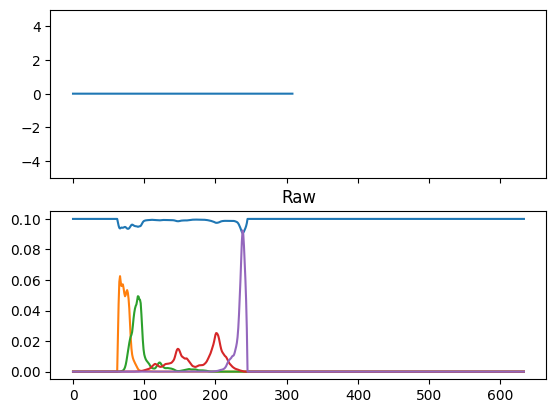

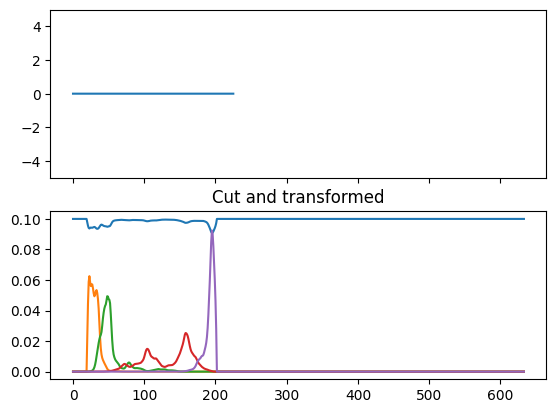

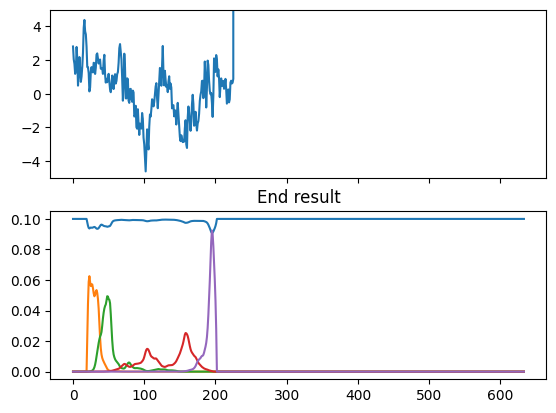

In [4]:
from hmpai.visualization import plot_epoch
epoch = train_data.__getitem__(0, debug=True)
# plot_epoch(epoch)
# get_masking_index(epoch[0])

In [5]:
model = base_mamba()
# 2 workers, ~18 b/s
# 4 workers, ~35 b/s
# 8 workers, ~48 b/s
# 12 workers, ~48 b/s
train_and_test(
    model,
    train_data,
    test_data,
    val_data,
    logs_path=Path("../logs/"),
    workers=8,
    batch_size=64,
    labels=labels,
    lr=0.0001,
    # lr=0.0005,
    # label_smoothing=0.1,
    # weight_decay=0.0001,
    do_spectral_decoupling=False,
    use_class_weights=False,
    class_weights=class_weights,
    whole_epoch=True,
    epochs=20,
)

  0%|          | 0/83 [00:00<?, ? batch/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /opt/conda/conda-bld/pytorch_1716905971132/work/aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv1d(input, weight, bias, self.stride,


  0%|          | 0/83 [00:00<?, ? batch/s]

  0%|          | 0/83 [00:00<?, ? batch/s]

  0%|          | 0/83 [00:00<?, ? batch/s]

  0%|          | 0/83 [00:00<?, ? batch/s]

  0%|          | 0/83 [00:00<?, ? batch/s]

  0%|          | 0/83 [00:00<?, ? batch/s]

  0%|          | 0/83 [00:00<?, ? batch/s]

  0%|          | 0/83 [00:00<?, ? batch/s]

  0%|          | 0/83 [00:00<?, ? batch/s]

  0%|          | 0/83 [00:00<?, ? batch/s]

  0%|          | 0/83 [00:00<?, ? batch/s]

  0%|          | 0/83 [00:00<?, ? batch/s]

  0%|          | 0/83 [00:00<?, ? batch/s]

[{'KLDivLoss': 5.200192928314209}]

In [ ]:
from torchinfo import summary

model = MambaModel(128, 19, len(labels), 
                   5, global_pool=False, dropout=0.1)

input_shape = (1, 638, 19)
summary(model, input_shape)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv1d(input, weight, bias, self.stride,


Layer (type:depth-idx)                   Output Shape              Param #
MambaModel                               [1, 638, 5]               4,883
├─Linear: 1-1                            [1, 638, 128]             2,560
├─Sequential: 1-2                        [1, 256, 638]             --
│    └─Conv1d: 2-1                       [1, 256, 638]             1,638,656
│    └─ReLU: 2-2                         [1, 256, 638]             --
├─Sequential: 1-3                        [1, 638, 256]             --
│    └─MambaBlock: 2-3                   [1, 638, 256]             --
│    │    └─Mamba: 3-1                   [1, 638, 256]             437,760
│    │    └─LayerNorm: 3-2               [1, 638, 256]             512
│    │    └─Dropout: 3-3                 [1, 638, 256]             --
│    └─MambaBlock: 2-4                   [1, 638, 256]             --
│    │    └─Mamba: 3-4                   [1, 638, 256]             437,760
│    │    └─LayerNorm: 3-5               [1, 638, 256]       

In [ ]:
model = SAT1GRU(64, 5)

train_and_test(
    model,
    train_data,
    test_data,
    val_data,
    logs_path=Path("../logs/"),
    workers=0,
    batch_size=128,
    labels=SAT_CLASSES_ACCURACY,
    label_smoothing=0.0001,
    weight_decay=0.01,
    lr=0.001,
    do_spectral_decoupling=False,
    use_class_weights=True,
    class_weights=class_weights,
)

In [ ]:
chk_path = Path("../models/gru100/checkpoint.pt")
checkpoint = load_model(chk_path)

model_kwargs = {
    "n_channels": len(dataset_sat1.channels),
    "n_samples": len(dataset_sat1.samples),
    "n_classes": len(dataset_sat1.labels),
}
model = SAT1GRU(**model_kwargs)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(DEVICE)

In [17]:
test_loader = DataLoader(test_data, 128, shuffle=False, num_workers=4, pin_memory=True)
results, pred, true = test(model, test_loader, None)
pred = pred.cpu()

In [22]:
test_loader = DataLoader(
    train_dataset_sat1, 128, shuffle=True, num_workers=4, pin_memory=True
)
results, pred, true = test(model, test_loader, None)
pred = pred.cpu()

In [ ]:
plot_confusion_matrix(true, pred, SAT1_STAGES_ACCURACY[1:])